In [1]:
import cubewalkers as cw
import cupy as cp
from copy import deepcopy
from io import StringIO

In [2]:
IMPORT_RULES_FROM_FILES = True
cc_models_dir = './models/cell_collective/'
if IMPORT_RULES_FROM_FILES:
    from os import listdir
    
    sync_models = {}
    for fname in listdir(cc_models_dir):
        with open(cc_models_dir+fname) as rulefile:
            name = fname.strip('.txt')
            rules = rulefile.read()
            sync_models[name]=cw.Model(rules)
else:
    from cana.datasets.bio import load_all_cell_collective_models
    def cell_collective_models():
        return {BN.name:cw.Model(cw.conversions.network_rules_from_cana(BN)) 
                for BN in load_all_cell_collective_models()}
    sync_models = cell_collective_models()
    for name,model in sync_models.items():
        with open(cc_models_dir+name+'.txt','w') as rulefile:
            rulefile.write(model.rules)

total_models = len(sync_models)
async_models = deepcopy(sync_models)

In [3]:
def derrida_cell_coll(models, sync=True ,W=100000):
    derrida_coefficients = {}
    for model_idx, (model_name, model) in enumerate(models.items()):
        N = model.n_variables
        
        if sync:
            print(f"Calculating Derrida coefficient in synchronous for {model_name} ({N=},{W=}). . .")
            model.n_walkers = W
            derrida_coefficients[model_name] = float(model.derrida_coefficient(threads_per_block=(16,16)))
        else:
            print(f"Calculating Derrida coefficient in asynchronous for {model_name} ({N=},{W=}). . .")
            model.n_time_steps = N
            model.n_walkers = W // N
            derrida_asynch = cp.zeros((N+1))
            for node in model.vardict:
                di = model.dynamical_impact(source_var=node,maskfunction=cw.update_schemes.asynchronous,threads_per_block=(16,16))
                di = cp.sum(di, axis=1)
                derrida_asynch += di
            derrida_asynch /= N
            derrida_coefficients[model_name] = float(derrida_asynch[-1])
            
        print(f"Progress: {(model_idx+1)}/{total_models}")
    return derrida_coefficients

In [4]:
sync_derrida_coefficients = derrida_cell_coll(sync_models,sync=True)

Calculating Derrida coefficient in synchronous for T-LGL Survival Network 2011 Reduced Network (N=18,W=100000). . .
Progress: 1/74
Calculating Derrida coefficient in synchronous for TOL Regulatory Network (N=24,W=100000). . .
Progress: 2/74
Calculating Derrida coefficient in synchronous for B cell differentiation (N=22,W=100000). . .
Progress: 3/74
Calculating Derrida coefficient in synchronous for Death Receptor Signaling (N=28,W=100000). . .
Progress: 4/74
Calculating Derrida coefficient in synchronous for HCC1954 Breast Cell Line Short-term ErbB Network (N=16,W=100000). . .
Progress: 5/74
Calculating Derrida coefficient in synchronous for IL-1 Signaling (N=118,W=100000). . .
Progress: 6/74
Calculating Derrida coefficient in synchronous for T-LGL Survival Network 2011 (N=60,W=100000). . .
Progress: 7/74
Calculating Derrida coefficient in synchronous for Mammalian Cell Cycle (N=20,W=100000). . .
Progress: 8/74
Calculating Derrida coefficient in synchronous for Signaling in Macrophage 

In [5]:
async_derrida_coefficients = derrida_cell_coll(sync_models,sync=False)

Calculating Derrida coefficient in asynchronous for T-LGL Survival Network 2011 Reduced Network (N=18,W=100000). . .
Progress: 1/74
Calculating Derrida coefficient in asynchronous for TOL Regulatory Network (N=24,W=100000). . .
Progress: 2/74
Calculating Derrida coefficient in asynchronous for B cell differentiation (N=22,W=100000). . .
Progress: 3/74
Calculating Derrida coefficient in asynchronous for Death Receptor Signaling (N=28,W=100000). . .
Progress: 4/74
Calculating Derrida coefficient in asynchronous for HCC1954 Breast Cell Line Short-term ErbB Network (N=16,W=100000). . .
Progress: 5/74
Calculating Derrida coefficient in asynchronous for IL-1 Signaling (N=118,W=100000). . .
Progress: 6/74
Calculating Derrida coefficient in asynchronous for T-LGL Survival Network 2011 (N=60,W=100000). . .
Progress: 7/74
Calculating Derrida coefficient in asynchronous for Mammalian Cell Cycle (N=20,W=100000). . .
Progress: 8/74
Calculating Derrida coefficient in asynchronous for Signaling in Ma

In [6]:
print(f'{"":>80}\tsynch\tasynch')
for model_name in sorted(sync_models):
    synch = round(sync_derrida_coefficients[model_name],3)
    asynch = round(async_derrida_coefficients[model_name],3)
    print(f'{model_name:>80}\t{synch}\t{asynch}')

                                                                                	synch	asynch
                                                               Apoptosis Network	1.002	1.035
                                                 Arabidopsis thaliana Cell Cycle	1.272	1.217
                                                Aurora Kinase A in Neuroblastoma	1.051	1.06
                               B bronchiseptica and T retortaeformis coinfection	1.012	0.997
                                                          B cell differentiation	1.0	1.017
                                   BT474 Breast Cell Line Long-term ErbB Network	0.955	0.922
                                  BT474 Breast Cell Line Short-term ErbB Network	0.761	0.821
                                                       Bordetella bronchiseptica	1.008	0.993
                                Bortezomib Responses in U266 Human Myeloma Cells	0.975	1.003
                                                        Budding Yeast Ce

In [7]:
with open('./data/derrida_coefficients.csv','w') as f:
    for model_name in sorted(sync_models):
        f.write(f'{model_name},synchronous,{round(sync_derrida_coefficients[model_name],3)},')
        f.write(f'asynchronous,{round(async_derrida_coefficients[model_name],3)}\n')

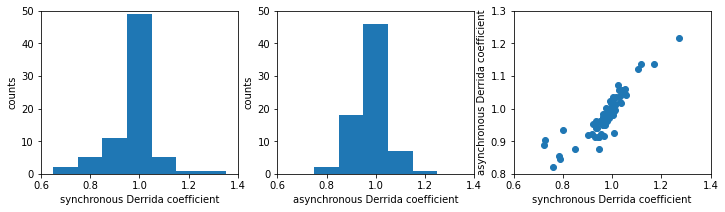

In [8]:
import matplotlib.pyplot as plt
import numpy as np

x = [j for (i,j) in sync_derrida_coefficients.items()]
y = [j for (i,j) in async_derrida_coefficients.items()]

plt.figure(figsize=(12, 3),facecolor='white')

plt.subplot(131)
counts, bins1 = np.histogram(x, bins=7, range=(0.65,1.35))
plt.hist(bins1[:-1], bins1, weights=counts)
plt.axis([0.6, 1.4, 0, 50])
plt.xlabel('synchronous Derrida coefficient')
plt.ylabel('counts')

plt.subplot(132)
counts, bins2 = np.histogram(y, bins=7, range=(0.65,1.35))
plt.hist(bins2[:-1], bins2, weights=counts)
plt.axis([0.6, 1.4, 0, 50])
plt.xlabel('asynchronous Derrida coefficient')
plt.ylabel('counts')

plt.subplot(133)
plt.scatter(x, y)
plt.xlabel('synchronous Derrida coefficient')
plt.ylabel('asynchronous Derrida coefficient')
plt.axis([0.6, 1.4, 0.8, 1.3])
plt.show()

In [9]:
def sourceless_derrida(model,sync=True,W=10000):
    if sync:
        maskfunction = cw.update_schemes.synchronous
        T = 1
        model.n_walkers = W
    else:
        maskfunction = cw.update_schemes.asynchronous
        T = model.n_variables
        model.n_walkers = W // T
    
    
    
    dc = 0
    n_ns = 0
    di = 0
    for rule in StringIO(model.rules):
        varname, func = rule.split(',')
        func = func.strip()
        if varname == func:
            continue
        n_ns += 1
        di += cp.sum(
            model.dynamical_impact(
                varname, 
                n_time_steps = T, 
                maskfunction=maskfunction,
                threads_per_block=(16,16)),
            axis=1)
    
    return di[-1]/n_ns


def derrida_cell_coll_sourceless(models, sync=True ,W=10000):
    derrida_coefficients_sourceless = {}
    for model_idx, (model_name, model) in enumerate(models.items()):
        derrida_coefficients_sourceless[model_name] = sourceless_derrida(model,sync=sync,W=W)
        print(f"Progress: {(model_idx+1)}/{total_models}")
    return derrida_coefficients_sourceless


In [10]:
dcs_sync = derrida_cell_coll_sourceless(sync_models)

Progress: 1/74
Progress: 2/74
Progress: 3/74
Progress: 4/74
Progress: 5/74
Progress: 6/74
Progress: 7/74
Progress: 8/74
Progress: 9/74
Progress: 10/74
Progress: 11/74
Progress: 12/74
Progress: 13/74
Progress: 14/74
Progress: 15/74
Progress: 16/74
Progress: 17/74
Progress: 18/74
Progress: 19/74
Progress: 20/74
Progress: 21/74
Progress: 22/74
Progress: 23/74
Progress: 24/74
Progress: 25/74
Progress: 26/74
Progress: 27/74
Progress: 28/74
Progress: 29/74
Progress: 30/74
Progress: 31/74
Progress: 32/74
Progress: 33/74
Progress: 34/74
Progress: 35/74
Progress: 36/74
Progress: 37/74
Progress: 38/74
Progress: 39/74
Progress: 40/74
Progress: 41/74
Progress: 42/74
Progress: 43/74
Progress: 44/74
Progress: 45/74
Progress: 46/74
Progress: 47/74
Progress: 48/74
Progress: 49/74
Progress: 50/74
Progress: 51/74
Progress: 52/74
Progress: 53/74
Progress: 54/74
Progress: 55/74
Progress: 56/74
Progress: 57/74
Progress: 58/74
Progress: 59/74
Progress: 60/74
Progress: 61/74
Progress: 62/74
Progress: 63/74
P

In [11]:
dcs_async = derrida_cell_coll_sourceless(async_models,sync=False)

Progress: 1/74
Progress: 2/74
Progress: 3/74
Progress: 4/74
Progress: 5/74
Progress: 6/74
Progress: 7/74
Progress: 8/74
Progress: 9/74
Progress: 10/74
Progress: 11/74
Progress: 12/74
Progress: 13/74
Progress: 14/74
Progress: 15/74
Progress: 16/74
Progress: 17/74
Progress: 18/74
Progress: 19/74
Progress: 20/74
Progress: 21/74
Progress: 22/74
Progress: 23/74
Progress: 24/74
Progress: 25/74
Progress: 26/74
Progress: 27/74
Progress: 28/74
Progress: 29/74
Progress: 30/74
Progress: 31/74
Progress: 32/74
Progress: 33/74
Progress: 34/74
Progress: 35/74
Progress: 36/74
Progress: 37/74
Progress: 38/74
Progress: 39/74
Progress: 40/74
Progress: 41/74
Progress: 42/74
Progress: 43/74
Progress: 44/74
Progress: 45/74
Progress: 46/74
Progress: 47/74
Progress: 48/74
Progress: 49/74
Progress: 50/74
Progress: 51/74
Progress: 52/74
Progress: 53/74
Progress: 54/74
Progress: 55/74
Progress: 56/74
Progress: 57/74
Progress: 58/74
Progress: 59/74
Progress: 60/74
Progress: 61/74
Progress: 62/74
Progress: 63/74
P

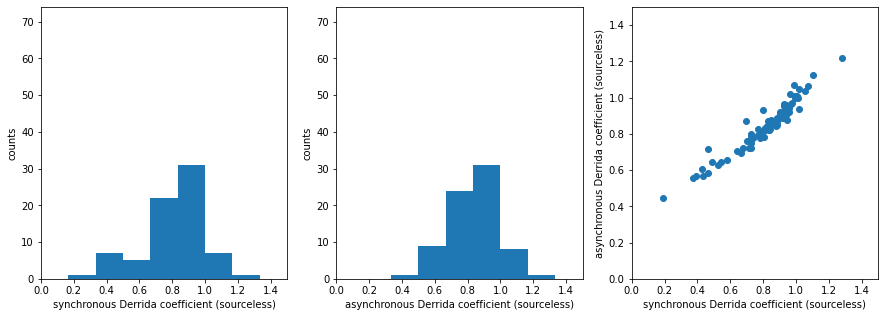

In [12]:
x = [float(j) for (i,j) in dcs_sync.items()]
y = [float(j) for (i,j) in dcs_async.items()]

plt.figure(figsize=(15, 5),facecolor='white')
range = [0,1.5]
cmax = 74
plt.subplot(131)
counts, bins1 = np.histogram(x, bins=9, range=range)
plt.hist(bins1[:-1], bins1, weights=counts)
plt.axis([range[0],range[1], 0, cmax])
plt.xlabel('synchronous Derrida coefficient (sourceless)')
plt.ylabel('counts')

plt.subplot(132)
counts, bins2 = np.histogram(y, bins=9, range=range)
plt.hist(bins2[:-1], bins2, weights=counts)
plt.axis([range[0],range[1], 0, cmax])
plt.xlabel('asynchronous Derrida coefficient (sourceless)')
plt.ylabel('counts')

plt.subplot(133)
plt.scatter(x, y)
plt.xlabel('synchronous Derrida coefficient (sourceless)')
plt.ylabel('asynchronous Derrida coefficient (sourceless)')
plt.axis([range[0],range[1], range[0],range[1]])
plt.show()

In [13]:
dcss=np.array([float(j) for (i,j) in dcs_sync.items()])
np.sum((dcss>=0.9) & (dcss<=1.1))

25

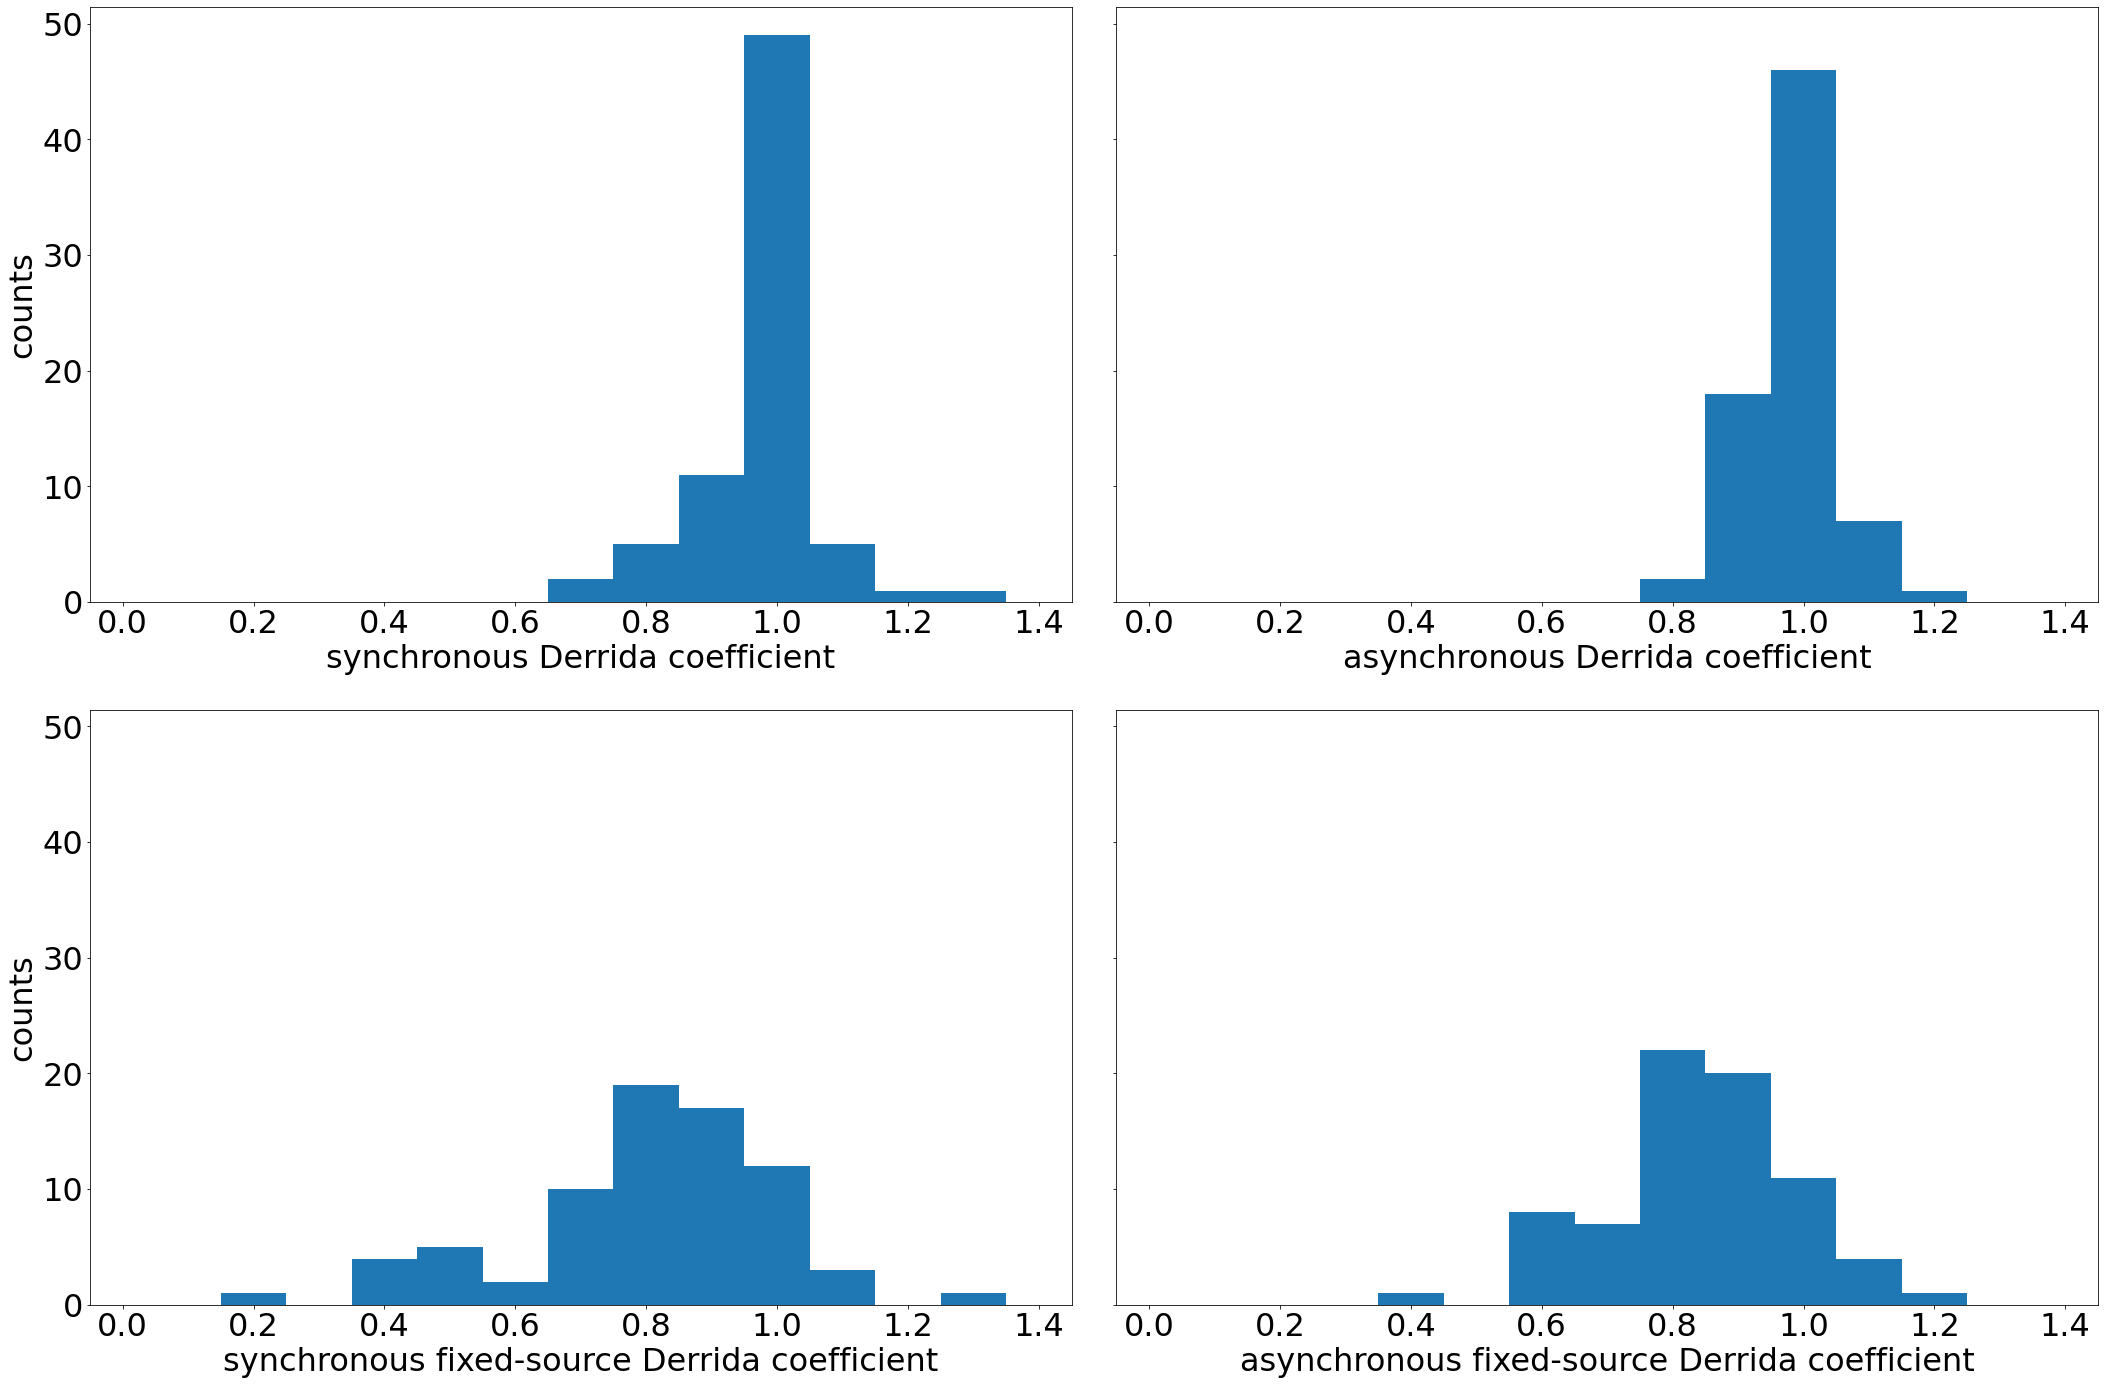

In [38]:
xns = [float(j) for (i,j) in dcs_sync.items()]
yns = [float(j) for (i,j) in dcs_async.items()]

x = [j for (i,j) in sync_derrida_coefficients.items()]
y = [j for (i,j) in async_derrida_coefficients.items()]
plt.rcParams.update({'font.size':32})
fig,ax = plt.subplots(2,2,figsize=(30,20),facecolor='white', sharey='all')


hval_range = (0-0.05,1.5-0.05)
nbins = 15

counts, bins = np.histogram(x, bins=nbins, range=hval_range)
ax[0,0].hist(bins[:-1], bins, weights=counts)
ax[0,0].set_xlim(hval_range)
ax[0,0].set_xlabel('synchronous Derrida coefficient')
ax[0,0].set_ylabel('counts')

counts, bins = np.histogram(y, bins=nbins, range=hval_range)
ax[0,1].hist(bins[:-1], bins, weights=counts)
ax[0,1].set_xlim(hval_range)
ax[0,1].set_xlabel('asynchronous Derrida coefficient')
# ax[0,1].set_ylabel('counts')

counts, bins = np.histogram(xns, bins=nbins, range=hval_range)
ax[1,0].hist(bins[:-1], bins, weights=counts)
ax[1,0].set_xlim(hval_range)
ax[1,0].set_xlabel('synchronous fixed-source Derrida coefficient')
ax[1,0].set_ylabel('counts')

counts, bins = np.histogram(yns, bins=nbins, range=hval_range)
ax[1,1].hist(bins[:-1], bins, weights=counts)
ax[1,1].set_xlim(hval_range)
ax[1,1].set_xlabel('asynchronous fixed-source Derrida coefficient')
# ax[1,1].set_ylabel('counts')
fig.tight_layout()
